In [2]:
# José Guilherme Goetten
# Jorge Luiz dos Santos Ramos Junior
# Yuri Carlos Bonifácio Neves

# WARNING: precisa de muitas dependências e python 2
# pip install pydub
# pip install scikits.talkbox (parece impossível no python 3, nem compilando o source do talkbox foi)
# instalar libav ffmpeg na mão e add no path
# atualizar scikit-learn para a versão 0.18.2 (pip install -U scikit-learn)
# e provavelmente mais alguma coisa

# criar a seguinte estrutura de diretórios:
# extrair a GTZAN (http://marsyasweb.appspot.com/download/data_sets/) em um diretório "input-au"
# "input-au", depois de extraída, deve ter 10 subdiretórios:
# "blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"
# depois criar diretórios "input-wav" e "~ceps", "~mspec", ~spec" (dependendo dos resultados do MFCC que quiser salvar)
# e criar a mesma estrutura de subdiretórios ("blues", ..., "rock") dentro de cada um


# precisão de 52.7% com LDA segundo 100-fold cross-validation com 1000 arquivos de treinamento

# algoritmo:
# 1. converte para wav
# 2. extrai MFCC de cada arquivo e salva no disco (para melhor desempenho)
# 3. lê os ceps e as labels de cada arquivo (X, y)
# 4. aplica LDA em cima dos ceps (foram testados vários classificadores aqui)
# 5. mostra umas métricas legais


# converte arquivos para wav (considerando tamanho fixo)
import os
from pydub import AudioSegment
import glob
# import wave

INPUT_PATH = "input-au\\"
WAV_PATH = "input-wav\\"


# converte os whatever para wav. deve funcionar para qualquer estrutura de pasta se existir a estrutura destino
for dirname, dirnames, filenames in os.walk(INPUT_PATH):
    for filename in filenames:
        ext = filename.split(".")[-1]
        print("convertendo", filename)
        wav_path = WAV_PATH + dirname.split("\\")[-1] + "\\" + filename + ".wav"
        wav_version = AudioSegment.from_file(dirname + "\\" + filename, format=ext)
        wav_version.export(wav_path, format="wav")

print ("done conversão para wav")

('convertendo', 'blues.00000.au')
('convertendo', 'blues.00001.au')
('convertendo', 'blues.00002.au')
('convertendo', 'blues.00003.au')
('convertendo', 'blues.00004.au')
('convertendo', 'blues.00005.au')
('convertendo', 'blues.00006.au')
('convertendo', 'blues.00007.au')
('convertendo', 'blues.00008.au')
('convertendo', 'blues.00009.au')
('convertendo', 'blues.00010.au')
('convertendo', 'blues.00011.au')
('convertendo', 'blues.00012.au')
('convertendo', 'blues.00013.au')
('convertendo', 'blues.00014.au')
('convertendo', 'blues.00015.au')
('convertendo', 'blues.00016.au')
('convertendo', 'blues.00017.au')
('convertendo', 'blues.00018.au')
('convertendo', 'blues.00019.au')
('convertendo', 'blues.00020.au')
('convertendo', 'blues.00021.au')
('convertendo', 'blues.00022.au')
('convertendo', 'blues.00023.au')
('convertendo', 'blues.00024.au')
('convertendo', 'blues.00025.au')
('convertendo', 'blues.00026.au')
('convertendo', 'blues.00027.au')
('convertendo', 'blues.00028.au')
('convertendo'

In [3]:
# salva os resultados do descritor mfcc no disco

import numpy as np
import scipy.io.wavfile
from scikits.talkbox.features import mfcc

WAV_PATH = "input-wav\\"

ceps = []
mspecs = []
specs = []

for dirname, dirnames, filenames in os.walk(WAV_PATH):
    for filename in filenames:
        sample_rate, wavdata = scipy.io.wavfile.read(dirname + "\\" + filename)
        wavdata[wavdata==0] = 1  # limpa os zeros para não dar divisão por zero depois
        ceps, mspec, spec = mfcc(wavdata)
        np.save("~ceps\\" + dirname.split("\\")[-1] + "\\" + filename + ".ceps", ceps) # 410 MB
        # np.save("~mspec\\" + dirname.split("\\")[-1] + "\\" + filename + ".mspec", mspec) # 1,23 GB
        # np.save("~spec\\" + dirname.split("\\")[-1] + "\\" + filename + ".spec", spec) # 15,7 GB ALDKSJFJLSKDF

print("done mfcc")

done mfcc


In [1]:
# lê os ceps gerados no passo anterior e os gêneros das músicas

import os
import numpy as np

CEPS_PATH = "~ceps\\"

ceps = []
labels = []
genre_dict = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3,
              'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
reverse_genre_dict = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco',
              4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}

for dirname, dirnames, filenames in os.walk(CEPS_PATH):
    for filename in filenames:
        ceps_arq = np.load(dirname + "\\" + filename)
        ceps.append(np.mean(ceps_arq, axis=0))
        # ceps.append(np.mean(ceps_arq[int(len(ceps_arq) / 10):int(len(ceps_arq) * 9 / 10)], axis=0))
        labels.append(genre_dict[dirname.split("\\")[-1]])

X = np.array(ceps)
y = np.array(labels)
print("done reading ceps")

done reading ceps


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.linear_model.logistic import LogisticRegression

# análise naive dos classificadores com 100-fold cross-validation
num_folds = 100
classifiers = [KNeighborsClassifier(), 
               DecisionTreeClassifier(), 
               GaussianNB(),
               SVC(),  # muito lento
               LogisticRegression(),
               LDA(),
               LDA(n_components=1, priors=None, shrinkage=None, solver='eigen', store_covariance=False, tol=0.0001)
              ]

for clf in classifiers:
    scores = cross_val_score(clf, X, y, cv=num_folds)
    print(clf.__class__.__name__, np.mean(scores))

('KNeighborsClassifier', 0.46799999999999992)
('DecisionTreeClassifier', 0.44400000000000001)
('GaussianNB', 0.50800000000000001)
('SVC', 0.46799999999999997)
('LogisticRegression', 0.49099999999999999)
('LinearDiscriminantAnalysis', 0.52700000000000002)
('LinearDiscriminantAnalysis', 0.495)


In [4]:
# LDA se revelou muito superior, então pequeno grid search para tentar otimizar um pouco mais
# (mas segundo a análise com 100-fold cross validation, não melhorou)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# split 75% treinamento e 25% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

# param_grid para a GridSearchCV:
param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
             'n_components': [1, 2, 3, 4, 5, 10, 100, None]}

clf = GridSearchCV(LDA(), param_grid)
clf.fit(X_train, y_train)
print(clf.best_estimator_)
# resultado:
# LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None, solver='eigen', store_covariance=False, tol=0.0001)


clf = LDA() # como não melhorou segundo a 100-fold cross-validation, usando LDA default
clf.fit(X_train, y_train)


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)
genre_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# print as métricas legais
print(classification_report(y_test, y_pred, target_names=genre_names))
print(confusion_matrix(y_test, y_pred))

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
             precision    recall  f1-score   support

      blues       0.61      0.44      0.51        25
  classical       0.78      0.72      0.75        25
    country       0.48      0.60      0.54        25
      disco       0.33      0.28      0.30        25
     hiphop       0.36      0.40      0.38        25
       jazz       0.53      0.36      0.43        25
      metal       0.62      0.84      0.71        25
        pop       0.70      0.76      0.73        25
     reggae       0.38      0.44      0.41        25
       rock       0.36      0.32      0.34        25

avg / total       0.52      0.52      0.51       250

[[11  1  0  0  2  4  2  0  0  5]
 [ 0 18  3  0  0  1  1  0  2  0]
 [ 1  0 15  2  0  2  0  3  2  0]
 [ 0  0  3  7  4  0  2  3  2  4]
 [ 0  0  2  1 10  0  3  2  5  2]
 [ 2  4  4  1  3  9  0  0  2  0]
 [ 1  0  0  0  1  0 21  0  

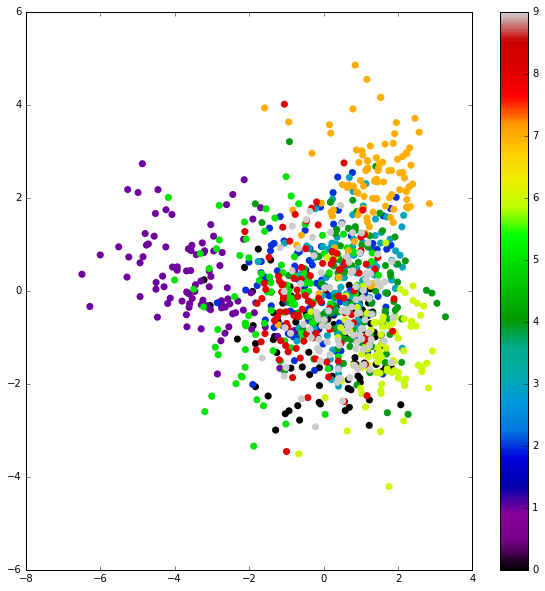

In [5]:
# plot legal do LDA

%matplotlib inline
import matplotlib.pyplot as plt

train = X
target = y

lda = LDA()
transform = lda.fit_transform(train, target)

plt.figure(figsize=(10,10))
plt.scatter(transform[:,0],transform[:,1], s=50, c = target, cmap = "nipy_spectral", edgecolor = "None")
plt.colorbar()
plt.clim(0,9) 